In [1]:
from sklearn.model_selection import train_test_split
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import torch.optim as optim
import random
from torch.utils.data import random_split
import copy

# Task 1

In [2]:
image_dir = r"C:\Users\Sarthak\Downloads\Confirmed_fronts\confirmed_fronts"

#### Pre-Preocessiong and Data Loading

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert('RGB')
        # image = pad_to_square(image)
        label = self.get_label(self.img_names[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_label(self, file_name):
        return int(file_name[0])

In [4]:
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])

dataset = CustomImageDataset(img_dir=image_dir, transform=transform)
dataset = datasets.ImageFolder(root=image_dir)

In [5]:
annotations = []

# Loop through the dataset to extract annotations from file names
for img_path, _ in dataset.samples:
    filename = os.path.basename(img_path)
    # label= filename.split("$$")[2]
    parts = filename.split("$$")
    annotations.append({
            "File_name" : img_path,
            "Brand_Name": parts[0],
            "Model_Name": parts[1],
            "Launch_Year": parts[2],
            "Color": parts[3],
            "Model_ID": parts[4],
            #"Advertiser_ID": parts[5],
            #"Image_ID": parts[6].split(".")[0]
        })

# Create a DataFrame from the annotations list
annotations_df = pd.DataFrame(annotations)


In [6]:
annotations_df['Launch_Year'] = annotations_df['Launch_Year'].astype(int)

conditions = [
    annotations_df['Launch_Year'] >= 2018,
    annotations_df['Launch_Year'] >= 2016,
    annotations_df['Launch_Year'] >= 2012,
    annotations_df['Launch_Year'] >= 2004
]

choices = [4, 3, 2, 1]

annotations_df['label'] = np.select(conditions, choices, default=0)

<Axes: >

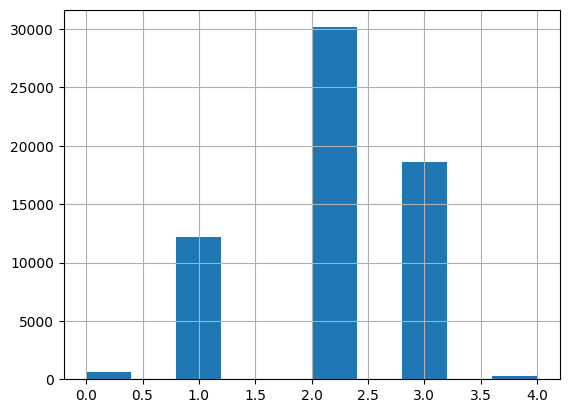

In [7]:
annotations_df.label.hist()

In [8]:
class CarDataset(Dataset):
    def __init__(self, annotations_file,
                 root_dir, transform=None, target_transform=None):
        self.annotations = annotations_file
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_name = os.path.join(f"{self.annotations.iloc[idx, 0]}")
        image = Image.open(img_name).convert("RGB")
        # image = pad_to_square(image)

        label = self.annotations.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)

        return image, label

Defining groups so that same models of the same year are not mixed in train, val and test sets.

In [9]:
groups = annotations_df.groupby(['Model_ID', 'Launch_Year'])

group_list = list(groups)

random.shuffle(group_list)
train_size = int(0.7 * len(group_list))
test_size = int(0.2 * len(group_list))
val_size = len(group_list) - train_size - test_size

train_groups = group_list[:train_size]
test_groups = group_list[train_size:train_size + test_size]
val_groups = group_list[train_size + test_size:]

train_df = pd.concat([group[1] for group in train_groups]).reset_index(drop=True)
test_df = pd.concat([group[1] for group in test_groups]).reset_index(drop=True)
val_df = pd.concat([group[1] for group in val_groups]).reset_index(drop=True)


In [10]:
dataset = CarDataset(annotations_file = annotations_df, root_dir=image_dir, transform= transform)
train_transform = transforms.Compose([
    transforms.Pad(12),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CarDataset(annotations_file =train_df, root_dir=image_dir, transform= transform)

val_dataset = CarDataset(annotations_file =val_df  , root_dir=image_dir, transform= transform)
test_dataset = CarDataset(annotations_file = test_df, root_dir=image_dir, transform= transform)

In [11]:
# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset) )
test_size = len(dataset)  - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Update the transforms for validation and test datasets
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



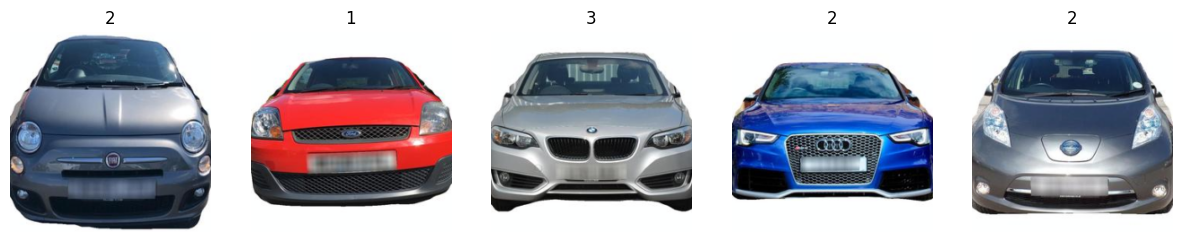

In [12]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    idx = random.sample(range(len(dataset)),num_images)

    for i in range(num_images):
        image, label = train_dataset[idx[i]]
        image = image.permute(1, 2, 0)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0, 1)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(label)
    plt.show()

show_images(test_df)

#### Task 1 Model Training

In [13]:
model = models.resnet18(pretrained=True)

num_categories = 5
model.fc = nn.Linear(model.fc.in_features, num_categories)
# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

model.fc

c:\Users\Sarthak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sarthak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=5, bias=True)

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
subset_indices = list(range(5000))
subset_indices_val = list(range(int(len(subset_indices)*0.1)))
subset_indices_tests = list(range(int(len(subset_indices)*0.2)))

subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
subset_sampler_val = torch.utils.data.SubsetRandomSampler(subset_indices_val)
subset_sampler_tests = torch.utils.data.SubsetRandomSampler(subset_indices_tests)

trial_train_loader = DataLoader(train_dataset, batch_size=64, sampler=subset_sampler)
trial_val_loader = DataLoader(val_dataset, batch_size=64, sampler=subset_sampler_val)
trial_test_loader = DataLoader(test_dataset, batch_size=64, sampler=subset_sampler_tests)


In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Move model to GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            labels = labels.long()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                labels = labels.long()
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        accuracy = 100 * correct / total
        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return model , accuracy

testing if model works for smaller sample and less epochs

In [17]:
model, acc = train_model(model, trial_train_loader, trial_val_loader, criterion, optimizer, scheduler, num_epochs=5)

c:\Users\Sarthak\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0/4, Loss: 0.1269
Validation Loss: 0.0399, Accuracy: 50.80%
Epoch 1/4, Loss: 0.1136
Validation Loss: 0.0381, Accuracy: 52.80%
Epoch 2/4, Loss: 0.1091
Validation Loss: 0.0380, Accuracy: 54.00%
Epoch 3/4, Loss: 0.1066
Validation Loss: 0.0391, Accuracy: 53.00%
Epoch 4/4, Loss: 0.1049
Validation Loss: 0.0368, Accuracy: 55.40%


In [19]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            labels = labels.long()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate_model(model, trial_test_loader, criterion)

Test Loss: 0.1510, Accuracy: 53.70%


Random search on one third train-set to get optimal parameters

In [21]:
# Function to create a ResNet-18 model with the specified number of classes
def create_model(num_classes):
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc.parameters():
        param.requires_grad = True
    return model

# Hyperparameter search space
lr_choices = [0.1, 0.01, 0.001]
batch_size_choices = [32, 64, 128]
num_epochs_choices = [10,15,20,25]

# Random search
num_trials = 8
best_acc = 0.0
best_params = None
best_model = None


for trial in range(num_trials):
    # Sample hyperparameters
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)

    # Create DataLoader with the sampled batch size
    subset_indices = list(range(15000))
    subset_indices_val = list(range(int(len(subset_indices)*0.1)))
    subset_indices_tests = list(range(int(len(subset_indices)*0.2)))

    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    subset_sampler_val = torch.utils.data.SubsetRandomSampler(subset_indices_val)
    subset_sampler_tests = torch.utils.data.SubsetRandomSampler(subset_indices_tests)

    trial_train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=subset_sampler)
    trial_val_loader = DataLoader(val_dataset, batch_size=batch_size, sampler=subset_sampler_val)
    trial_test_loader = DataLoader(test_dataset, batch_size=batch_size, sampler=subset_sampler_tests)

    # Create model
    model = create_model(5).to(device)

    num_epochs=random.choice(num_epochs_choices)
    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = optim.Adam(model.fc.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Train and evaluate the model
    print(f"Trial {trial + 1}/{num_trials}: lr={lr}, batch_size={batch_size}")
    model, accuracy = train_model(model, trial_train_loader, trial_val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs)
   #print(model)
    #print(accuracy)
    # Save the best model
    if accuracy > best_acc:
        best_acc = accuracy
        print(best_acc)
        best_params = {'lr': lr, 'batch_size': batch_size, 'num_epochs':num_epochs}
        best_model = model
   

    print(f"Best accuracy: {best_acc:.2f}% with parameters: {best_params}")
# Define the validate function
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    corrects = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_acc = corrects.double() / len(test_loader.dataset)
    return epoch_loss, epoch_acc
# Test the best model


Trial 1/8: lr=0.001, batch_size=32
Epoch 0/14, Loss: 0.3497
Validation Loss: 0.1161, Accuracy: 54.27%
Epoch 1/14, Loss: 0.3212
Validation Loss: 0.1108, Accuracy: 55.93%
Epoch 2/14, Loss: 0.3127
Validation Loss: 0.1097, Accuracy: 57.13%
Epoch 3/14, Loss: 0.3075
Validation Loss: 0.1083, Accuracy: 57.47%
Epoch 4/14, Loss: 0.3083
Validation Loss: 0.1098, Accuracy: 57.00%
Epoch 5/14, Loss: 0.3039
Validation Loss: 0.1138, Accuracy: 53.60%
Epoch 6/14, Loss: 0.3045
Validation Loss: 0.1129, Accuracy: 55.80%
Epoch 7/14, Loss: 0.2911
Validation Loss: 0.1067, Accuracy: 58.80%
Epoch 8/14, Loss: 0.2901
Validation Loss: 0.1065, Accuracy: 59.13%
Epoch 9/14, Loss: 0.2895
Validation Loss: 0.1066, Accuracy: 58.47%
Epoch 10/14, Loss: 0.2895
Validation Loss: 0.1071, Accuracy: 57.80%
Epoch 11/14, Loss: 0.2886
Validation Loss: 0.1066, Accuracy: 58.87%
Epoch 12/14, Loss: 0.2895
Validation Loss: 0.1070, Accuracy: 58.20%
Epoch 13/14, Loss: 0.2895
Validation Loss: 0.1070, Accuracy: 58.33%
Epoch 14/14, Loss: 0.28

Model training on full dataset

In [22]:
model_full = models.resnet18(pretrained=True)

num_categories = 5
model_full.fc = nn.Linear(model_full.fc.in_features, num_categories)
for param in model_full.parameters():
    param.requires_grad = False
for param in model_full.fc.parameters():
    param.requires_grad = True

model_full.fc
model_full.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
optimizer = optim.Adam(model_full.fc.parameters(), lr=0.001)
train_loader_full = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader_full = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader_full = DataLoader(test_dataset, batch_size=128, shuffle=False)
full_model, full_acc = train_model(model_full, train_loader_full, val_loader_full, criterion, optimizer, scheduler, num_epochs=20)

Epoch 0/19, Loss: 0.9904
Validation Loss: 0.9434, Accuracy: 55.58%
Epoch 1/19, Loss: 0.9052
Validation Loss: 0.9322, Accuracy: 54.64%
Epoch 2/19, Loss: 0.8869
Validation Loss: 0.8875, Accuracy: 58.46%
Epoch 3/19, Loss: 0.8714
Validation Loss: 0.8846, Accuracy: 57.96%
Epoch 4/19, Loss: 0.8656
Validation Loss: 0.8871, Accuracy: 57.91%
Epoch 5/19, Loss: 0.8599
Validation Loss: 0.8699, Accuracy: 59.51%
Epoch 6/19, Loss: 0.8566
Validation Loss: 0.9095, Accuracy: 57.02%
Epoch 7/19, Loss: 0.8555
Validation Loss: 0.8881, Accuracy: 58.38%
Epoch 8/19, Loss: 0.8532
Validation Loss: 0.8799, Accuracy: 58.63%
Epoch 9/19, Loss: 0.8496
Validation Loss: 0.8717, Accuracy: 59.85%
Epoch 10/19, Loss: 0.8477
Validation Loss: 0.8737, Accuracy: 59.59%
Epoch 11/19, Loss: 0.8502
Validation Loss: 0.8720, Accuracy: 59.43%
Epoch 12/19, Loss: 0.8484
Validation Loss: 0.8847, Accuracy: 58.41%
Epoch 13/19, Loss: 0.8428
Validation Loss: 0.8645, Accuracy: 59.76%
Epoch 14/19, Loss: 0.8415
Validation Loss: 0.8719, Accurac

#### Model Testing

In [24]:
evaluate_model(model, test_loader_full, criterion)

Test Loss: 0.8875, Accuracy: 58.76%


#### Visualizing outputs of modernity

In [25]:
print_subset_indices = list(range(5))
print_subset_sampler = torch.utils.data.SubsetRandomSampler(print_subset_indices)
print_train_loader = DataLoader(val_dataset, batch_size=5, sampler=print_subset_sampler)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


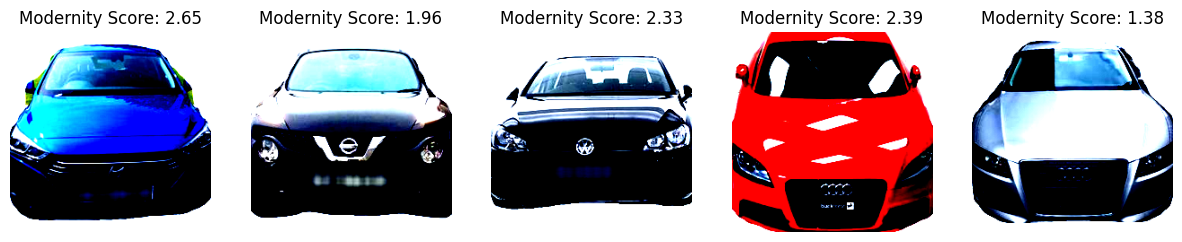

In [26]:
def visualize_modernity_scores(model, dataloader):
    model.eval()
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            scores = torch.softmax(outputs, dim=1)
            modernity_scores = (scores * torch.arange(5).to(device)).sum(dim=1)
            
        fig, axes = plt.subplots(1, len(inputs), figsize=(15, 5))
        for i in range(len(inputs)):
            img = inputs[i].cpu().permute(1, 2, 0).numpy()
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f'Modernity Score: {modernity_scores[i].item():.2f}')
        plt.show()

visualize_modernity_scores(model, print_train_loader)